# Get Data and Visualize

In [64]:
# import numpy, pandas for data manipulation
import numpy as np
import pandas as pd

# import matplotlib, seabron
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [65]:
# import data
weather_data = pd.read_csv('../Project-2 Code/climate_data.csv')

# Check Dataset shape
print(weather_data.shape)

# select the data and temperature columns
temp_df = weather_data[['Date', 'Average temperature (°F)']]

# rename column
temp_df = temp_df.rename(columns={'Average temperature (°F)':'avg_temp'})

temp_df.head(10)

(3902, 23)


,Date,avg_temp
0,2009-01-01,37.8
1,2009-01-02,43.2
2,2009-01-03,25.7
3,2009-01-04,9.3
4,2009-01-05,23.5
5,2009-01-06,24.8
6,2009-01-07,34.2
7,2009-01-08,42.1
8,2009-01-09,30.3
9,2009-01-10,26.2


In [66]:
# select the subset datea from 2015 - 2019
mask = (temp_df['Date'] >= '2017-01-01') & (temp_df['Date'] <= '2020-07-28')
temp_df = temp_df.loc[mask]

# reset index
temp_df.set_index('Date', inplace=True)

# iunpect first 5 rows and loast 5 rows of the data
from IPython.display import display
display(temp_df.head(5))
display(temp_df.tail(5))

,avg_temp
Date,
2017-01-01,33.4
2017-01-02,28.5
2017-01-03,16.8
2017-01-04,12.6
2017-01-05,-2.4


,avg_temp
Date,
2020-07-24,64.1
2020-07-25,62.8
2020-07-26,60.6
2020-07-27,61.7
2020-07-28,60.5


In [67]:
# describe
temp_df.describe()

,avg_temp
count,1229.000000
mean,44.693328
std,15.270384
min,-2.400000
25%,33.800000
50%,45.000000
75%,58.400000
max,76.300000


In [68]:
# Output the max and min temps
print(temp_df.loc[temp_df['avg_temp'] == temp_df['avg_temp'].max()])
print(temp_df.loc[temp_df['avg_temp'] == temp_df['avg_temp'].min()])

            avg_temp
Date                
2020-07-18      76.3
            avg_temp
Date                
2017-01-05      -2.4


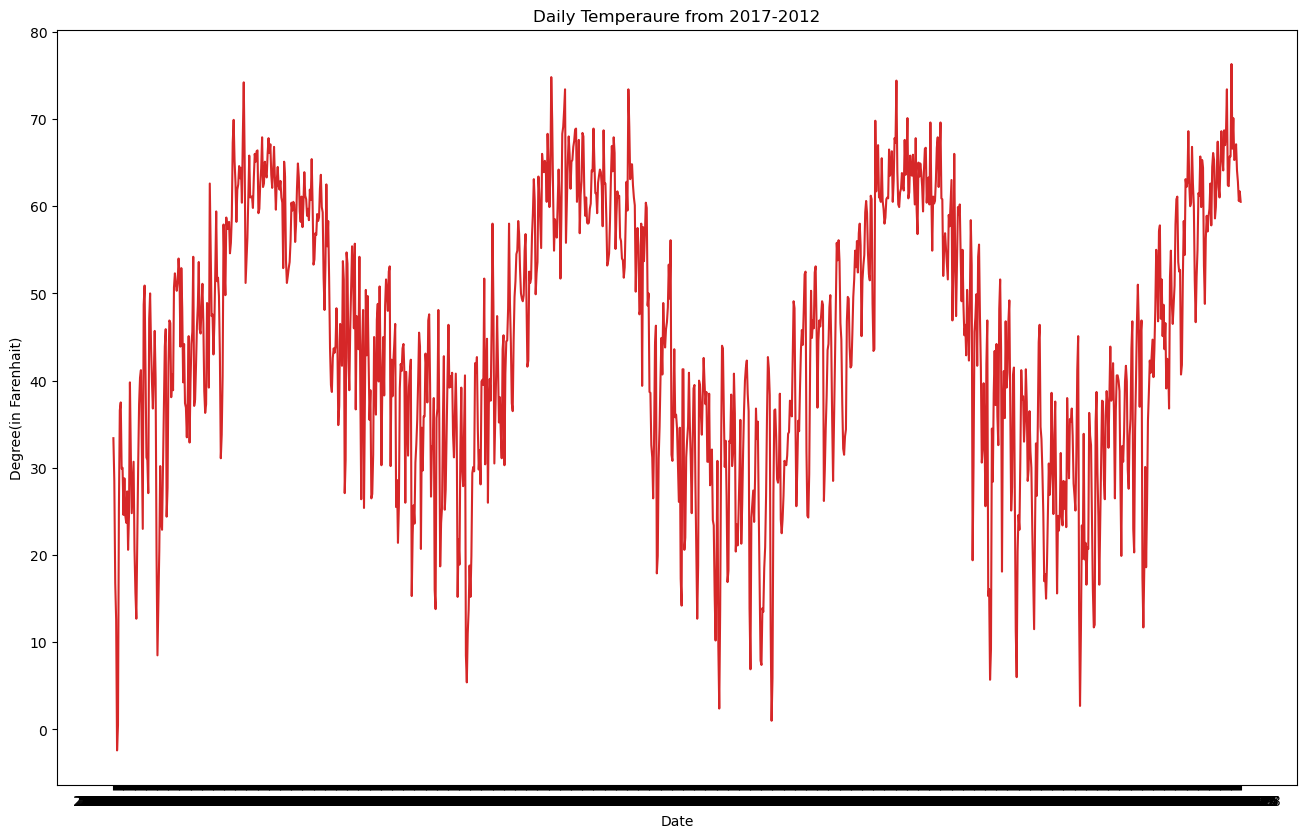

In [69]:
# plot the daily temperature change
plt.figure(figsize=(16,10), dpi=100)
plt.plot(temp_df.index, temp_df.avg_temp, color='tab:red')
plt.gca().set(title='Daily Temperaure from 2017-2012', xlabel='Date', ylabel='Degree(in Farenhait)')
plt.show()

<AxesSubplot:xlabel='Date'>

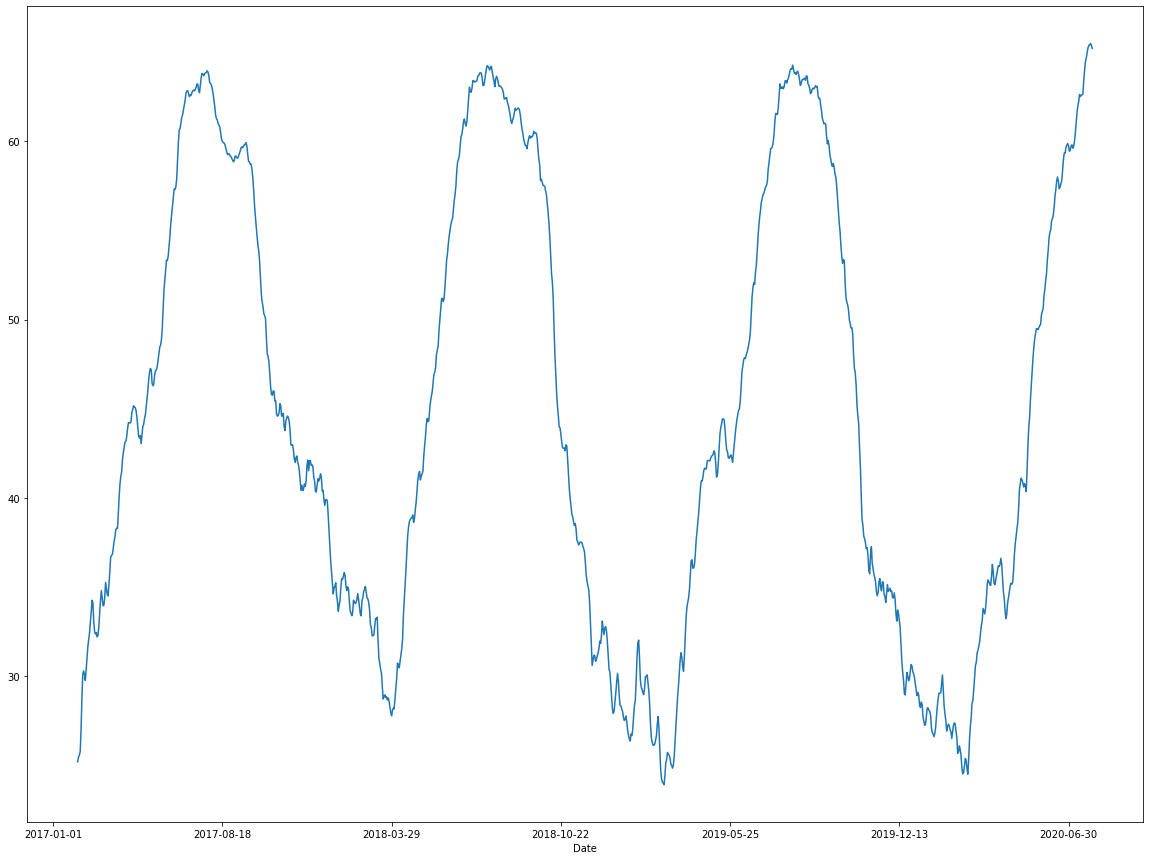

In [70]:
# Apply the moving Average function by a subset of size 30 days
temp_df_mean = temp_df.avg_temp.rolling(window=30).mean()
temp_df_mean.plot(figsize=(20,15))

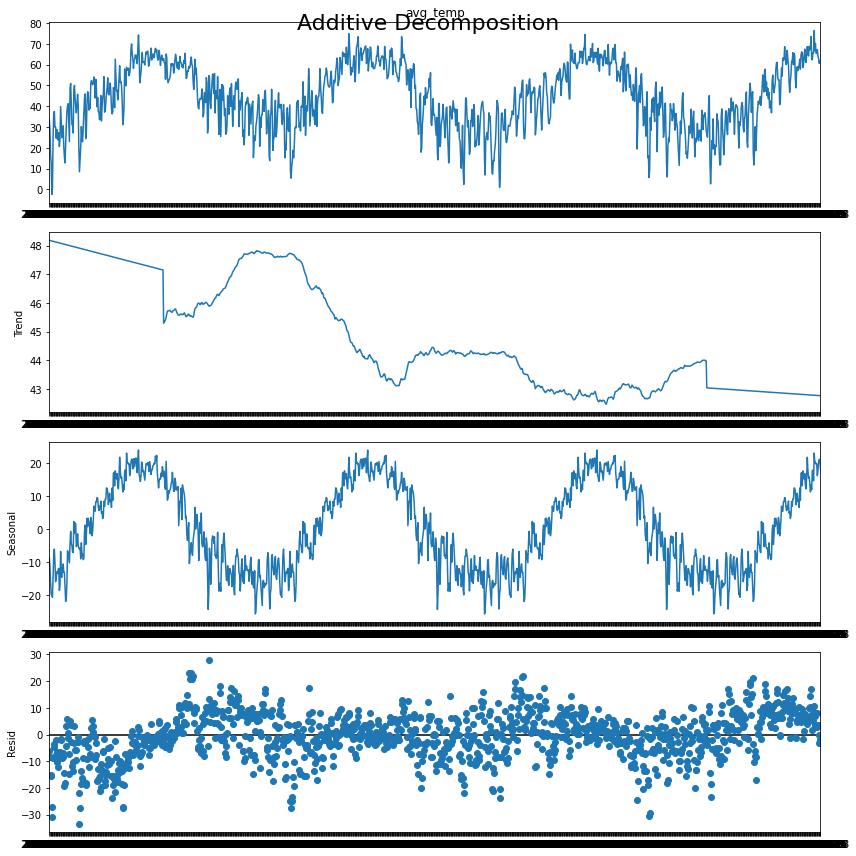

In [71]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(temp_df.avg_temp, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize':(12,12)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

# Baseline Model
predict the weather based on an assumption. The air temperature today depends on the air temperature yesterday, the air temperature yesterday depends on the day before yesterday, and so on.

In [72]:
# Shift the current temperature to the next day
predicted_df = temp_df['avg_temp'].to_frame().shift(1).rename(columns={'avg_temp':'avg_temp_pred'})
actual_df = temp_df['avg_temp'].to_frame().rename(columns={'avg_temp':'avg_temp_actual'})

# concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df], axis=1)

# Select from the second row because there is no predictions for today due to the shifting/
one_step_df = one_step_df[1:]
one_step_df.head(10)

,avg_temp_actual,avg_temp_pred
Date,,
2017-01-02,28.5,33.4
2017-01-03,16.8,28.5
2017-01-04,12.6,16.8
2017-01-05,-2.4,12.6
2017-01-06,0.5,-2.4
2017-01-07,25.2,0.5
2017-01-08,36.6,25.2
2017-01-09,37.5,36.6
2017-01-10,29.9,37.5


In [73]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# calculate the RMSE
temp_pred_err = sqrt(MSE(one_step_df.avg_temp_actual, one_step_df.avg_temp_pred))
print('The RMSE is',temp_pred_err)

The RMSE is 7.502758993073369


the RMSE is a little high. Meaning the predictions will be of by 7 degrees F. This is somewhat acceptable in weather forecasting since there are many other factors that affect the temperature

# SARIMA Model

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal SARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality.

In [76]:
import itertools

# define the p, d, and q parameters to take any value between 0 and 2
p = d = q = range(0,2)

# Geneerate all different combinations of p, b and q triplets
pdq = list(itertools.product(p,d,q))

# Generate all differen combincations of season p, b, and q triplets
seasonal_pdq = [(x[0], x[1],x[2], 23) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combincations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[4]))

Examples of parameter combincations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 23)
SARIMAX: (0, 0, 1) x (0, 1, 0, 23)
SARIMAX: (0, 0, 1) x (0, 1, 1, 23)
SARIMAX: (0, 0, 1) x (1, 0, 0, 23)


The AIC measures how well a model fits the data while taking into account the overall complexity of the model. We are interested in finding the model that yields the lower AIC value

In [78]:
import warnings
warnings.filterwarnings('ignore') 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(one_step_df.avg_temp_actual,
                                              order = param,
                                              seasonal_order = param_seasonal,
                                              enforce_stationarity = False,
                                              enforce_invertibility = False)
            results = model.fit()
            
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

# Fit the Model

In [80]:
# import the statsmodel library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
model = sm.tsa.statespace.SARIMAX(one_step_df.avg_temp_actual,
                                  order = (1,1,1),
                                  season_order = (1,1,1,12),
                                  enforce_stationarity = False,
                                  enforce_inertability = False)
results = model.fit()

# Model Diagnostics

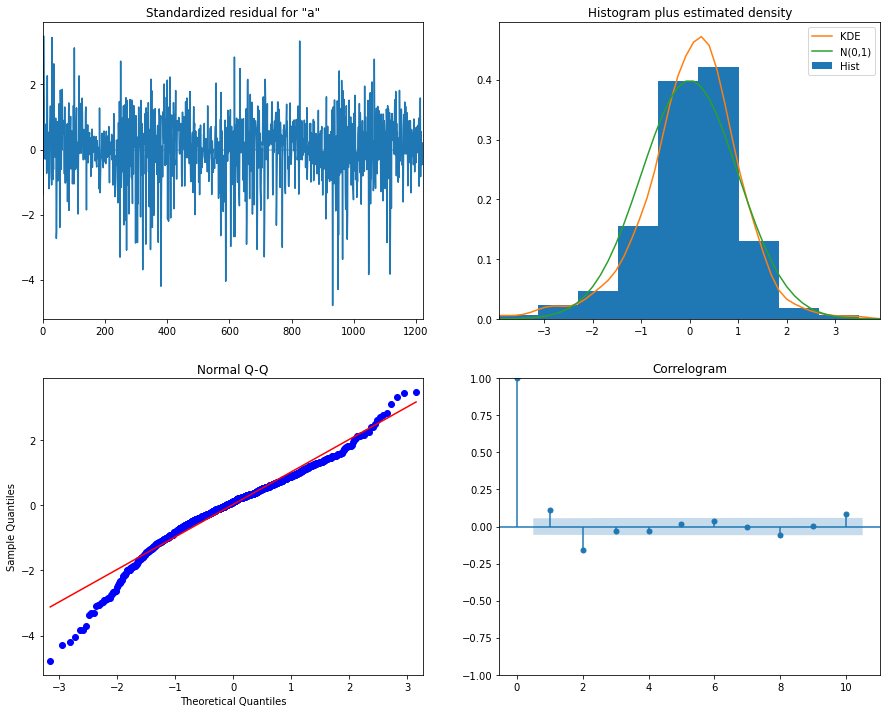

In [81]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

we want to ensure that the residuals of our models are uncorrelated and normally distribuved with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it's a good indication that it can be further imporved.

- the histogram shows us the orange KDE line follows closely with the N(0,1) line. The N(0,1) is the standatd notation for a normal distribution with mean 0 and standard deviation of 1. this graph indicates that the reisudla are somewhat normally distributed.


- the bottom left plot (Q-Q plot) shows that the ordered distribution of the risiduals, for the most part, follows the linear trend taken from a standard normal distribution with N(0,1). this is a strong indication that the residuals are normally distributed.


- the top left plot shows residuals over time and it does not diplay any obvious seasonality, as it seems to just be noise. this is confirmed byu the correlogram (bottom right plot), which tells us that the time series residuals have low correlation with lagged versions of itself


With these observations, we can conclude that our model produces a statisfactory fit that could help us understand our time series data and forcase future values.

# Validating Non-Dynamic Forcast

The get_predcition() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series

In [162]:
# set forecast to start at 2018-05-19
pred = results.get_prediction(start='2018-04-15', dynamic=False)
pred_ci = pred.conf_int()

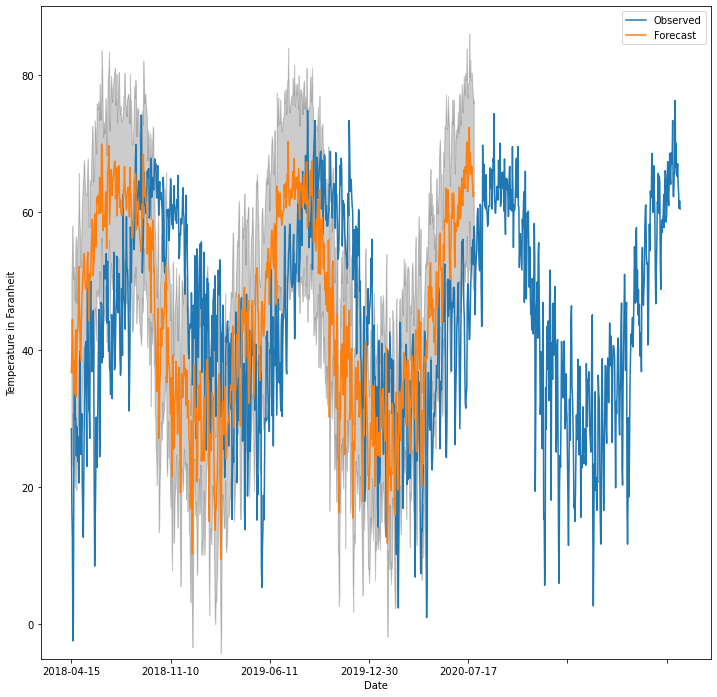

In [165]:
ax = one_step_df.avg_temp_actual['2016':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature in Faranheit')
plt.ylim([-5,90])
plt.legend()
plt.show()

*insert obervation here when showing graph correctly*

# Non-Dynamic Forecast Diagnostic

In [168]:
# Extract the predicted and true values of our time series

y_forecasted = pred.predicted_mean
y_actual = one_step_df.avg_temp_actual['2018-04-15':]
print(y_forecasted.shape)
print(y_actual.shape)

# calculate the MSE
mse = MSE(y_actual, y_forecasted, squared=True)
print('The MSE is',round(mse,2))

(812,)
(812,)
The MSE is 45.65


This is ridiculouly high, and is not a very good predictor what so ever

# Validatin Dynamic Forecast

In [175]:
pred_dynamic = results.get_prediction(start='2018-04-15', dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

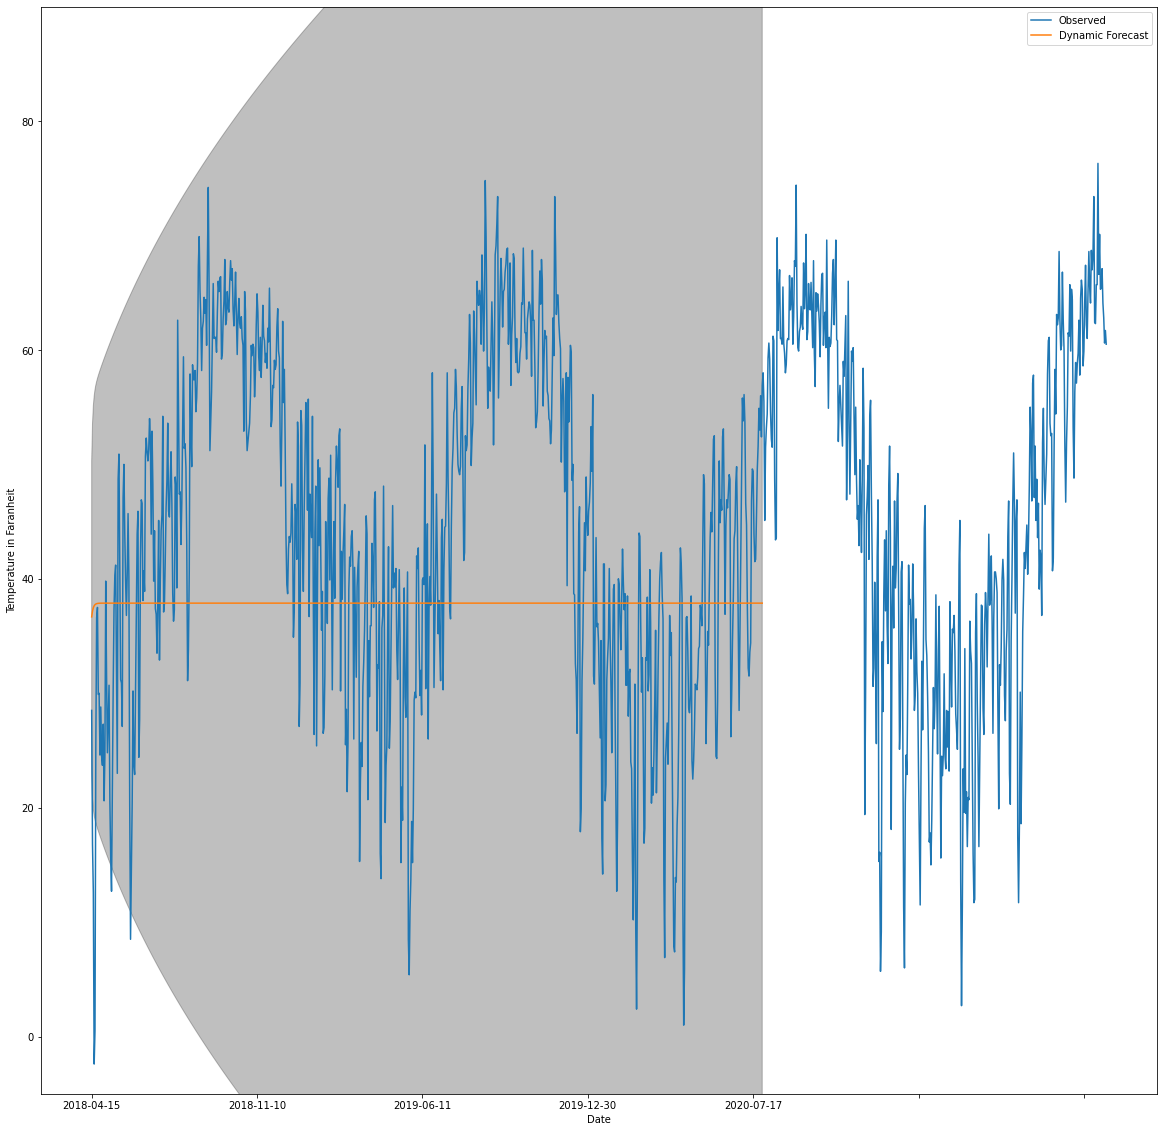

In [176]:
# plot the real and forecasted values of the average daily temperature to assess how well we did

ax = one_step_df.avg_temp_actual['2016':].plot(label='Observed', figsize=(20,20))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature in Faranheit')
plt.ylim([-5,90])
plt.legend()
plt.show()

This model does not seem to predict the temperature accuratly. NEEDS WORK!!

# Dynamic Forecast Diagnostics

In [177]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_actual = one_step_df.avg_temp_actual['2018-04-15':]

# Calculate MSE
mse = sqrt(MSE(y_actual, y_forecasted).mean())
print('The MSE is',round(mse,2))

The MSE is 17.37


The MSE for the Dynamic Forcase dropped Significantly!! 